# Part 4 - Morphology and Segmentation

## Basic morphology operations with scikit-image

In [1]:
from skimage import io, color, util, filters
from skimage import exposure, transform, morphology, measure
import numpy as np
import matplotlib

/anaconda3/envs/ImPyClass/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda3/envs/ImPyClass/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/anaconda3/envs/ImPyClass/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


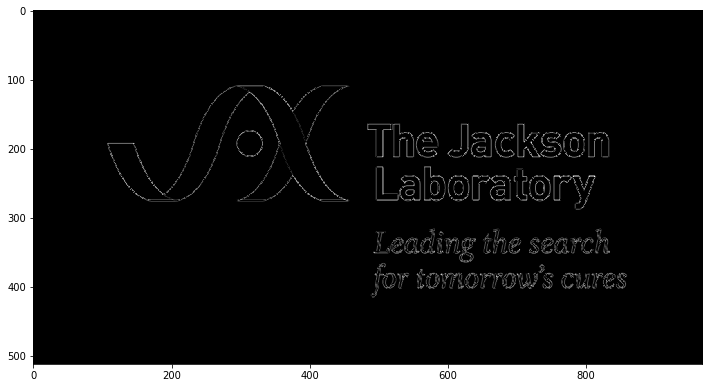

In [2]:
# Lets get our edge map back (see Part 3 for explanation of this code)
jax2 = io.imread('../data/jax.jpeg')
jax2 = transform.rescale(jax2, .5)
jax2_gray = color.rgb2gray(jax2)
jax2_gray = util.invert(jax2_gray)
jax2_edges = filters.laplace(jax2_gray)

jax2_edges = abs(jax2_edges)
jax2_edges = exposure.rescale_intensity(jax2_edges, in_range='image', out_range='uint8')
jax2_edges = jax2_edges.astype('uint8')

matplotlib.rcParams['figure.figsize'] = [10.0, 10.0] 
io.imshow(jax2_edges);

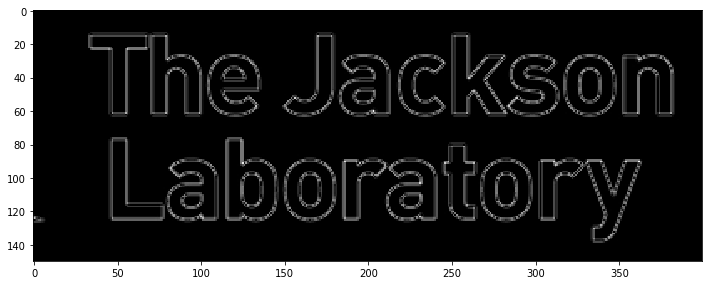

In [3]:
io.imshow(jax2_edges[150:300, 450:850]);

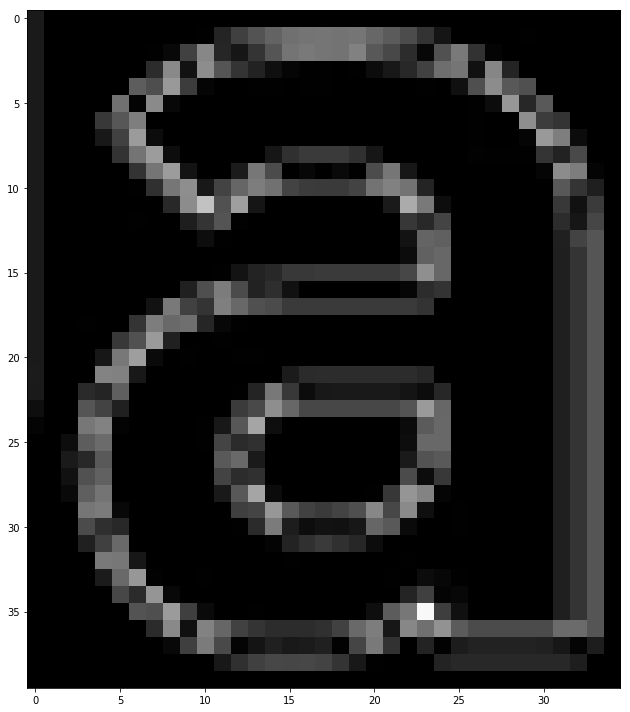

In [4]:
io.imshow(jax2_edges[175:215, 630:665]);

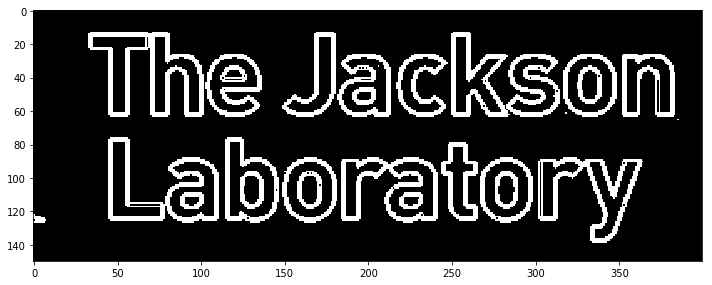

In [5]:
# This produces a binary outline...
jax_outline = jax2_edges > 1
io.imshow(jax_outline[150:300, 450:850]);

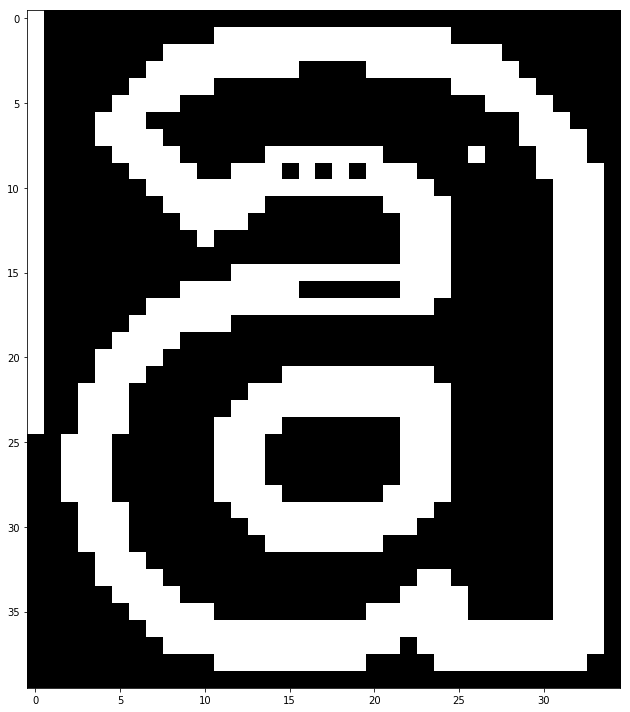

In [6]:
# ...but it is a little messy
io.imshow(jax_outline[175:215, 630:665]);

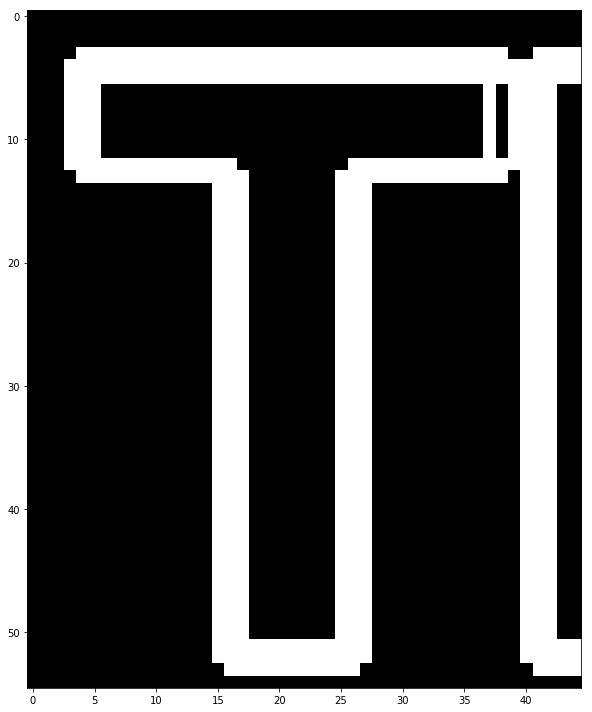

In [7]:
io.imshow(jax_outline[160:215, 480:525]);

In [8]:
# Note that this is actually a boolean array
jax_outline[175:215, 630:665]

array([[ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       ...,
       [False, False, False, ...,  True,  True, False],
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False, False, False]])

--------
## Slides covering dilation and erosion
--------

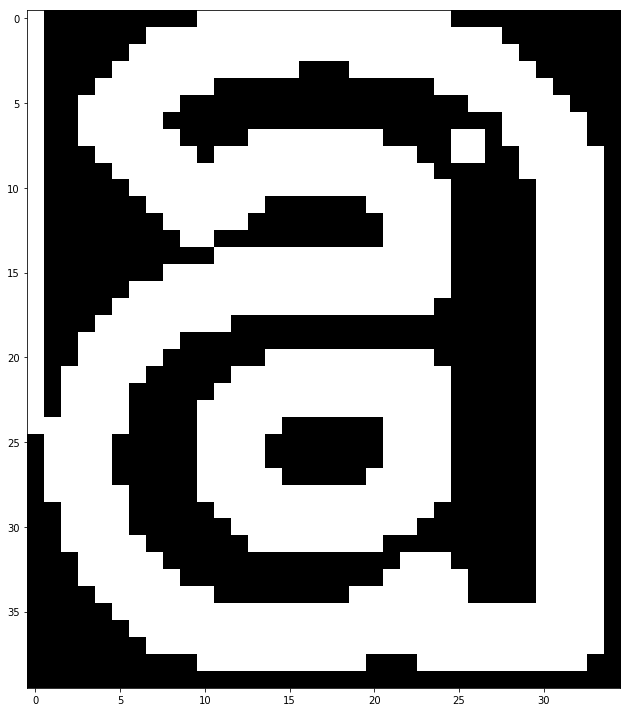

In [9]:
# First we need to create a structuring element ("selem")
selem = morphology.square(2)

# Now use the structuring element to dilate
jax_outline_dilate =  morphology.binary_dilation(jax_outline, selem = selem)
io.imshow(jax_outline_dilate[175:215, 630:665]);

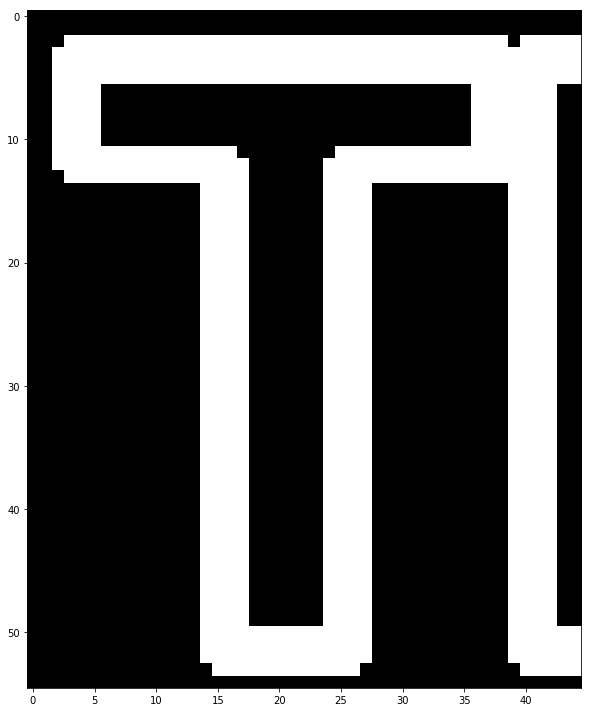

In [10]:
io.imshow(jax_outline_dilate[160:215, 480:525]);

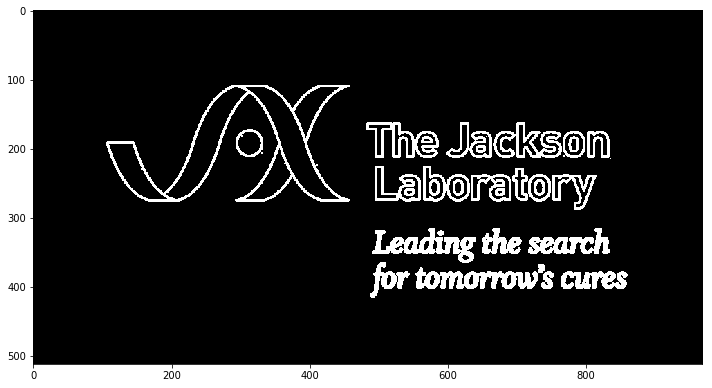

In [11]:
io.imshow(jax_outline_dilate);

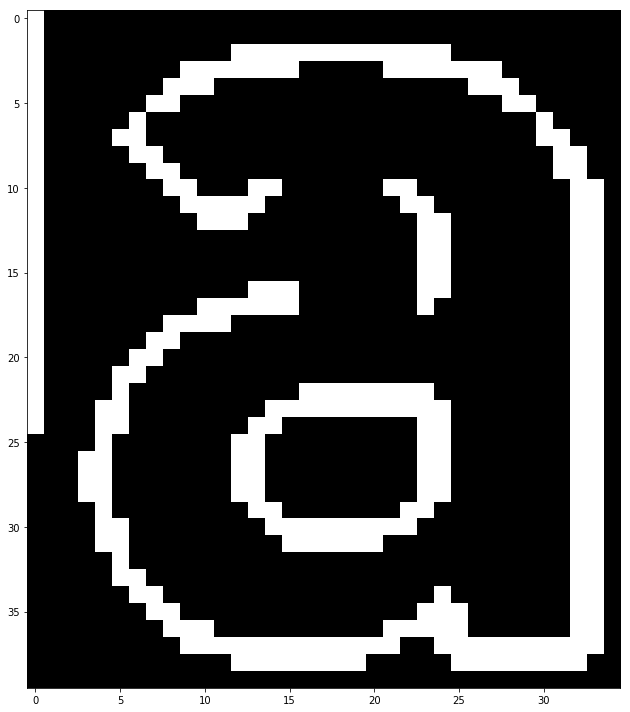

In [12]:
# What would have erosion done?

jax_outline_erode =  morphology.binary_erosion(jax_outline, selem = selem)
io.imshow(jax_outline_erode[175:215, 630:665]);

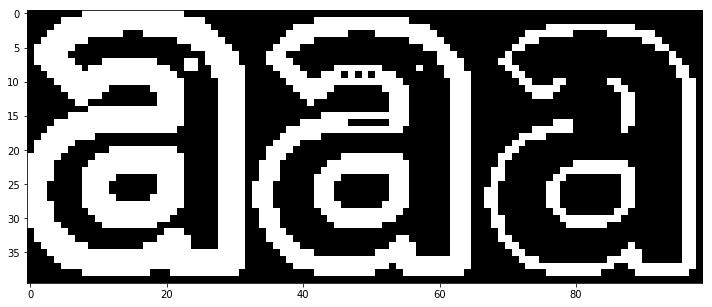

In [13]:
# Lets compare all three operations

image_row_1 = jax_outline_dilate[175:215, 632:665]
image_row_2 = jax_outline[175:215, 632:665]
image_row_3 = jax_outline_erode[175:215, 632:665]

image_row = np.hstack((image_row_1, image_row_2, image_row_3))

io.imshow(image_row);


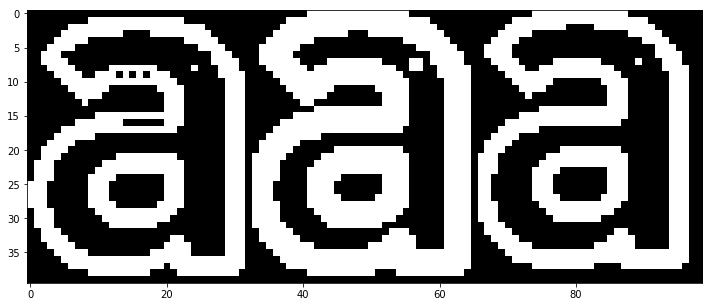

In [14]:
# What if you follow up a dilation with an erosion?
jax_dilate_erode = morphology.erosion(jax_outline_dilate, selem=selem)

image_row_1 = jax_outline[175:215, 632:665]
image_row_2 = jax_outline_dilate[175:215, 632:665]
image_row_3 = jax_dilate_erode[175:215, 632:665]

image_row = np.hstack((image_row_1, image_row_2, image_row_3))

io.imshow(image_row);

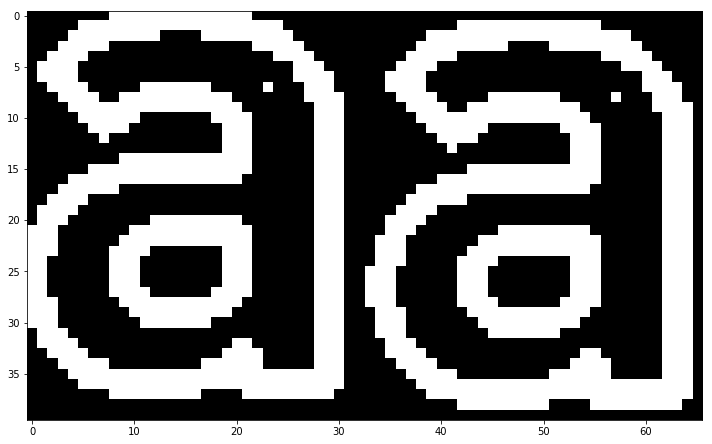

In [15]:
# A dilation followed by an erosion is also called 'closing'
jax_closing = morphology.closing(jax_outline, selem=selem)

# Lets compare dilation->erosion (left) to closing (right)
image_row_1 = jax_dilate_erode[175:215, 632:665]
image_row_2 = jax_closing[175:215, 632:665]

image_row = np.hstack((image_row_1, image_row_2))

io.imshow(image_row);

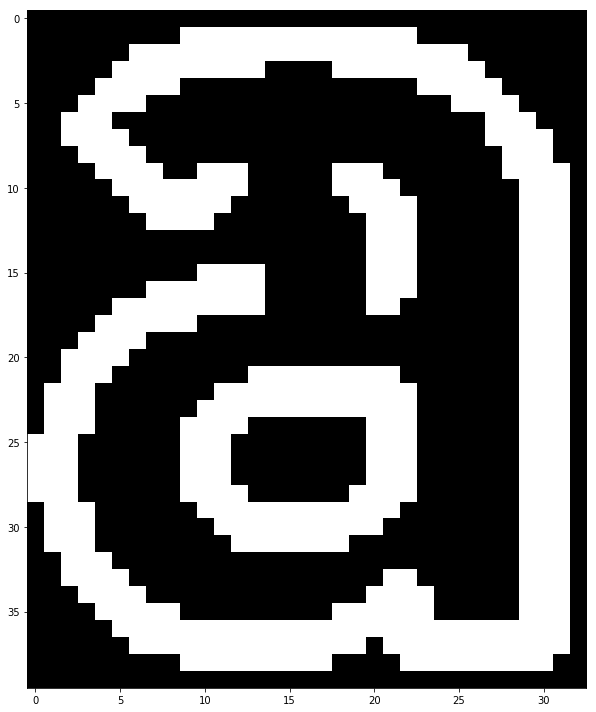

In [16]:
# an erosion followed by a dilation is called 'opening'
jax_opening = morphology.opening(jax_outline, selem=selem)

io.imshow(jax_opening[175:215, 632:665]);

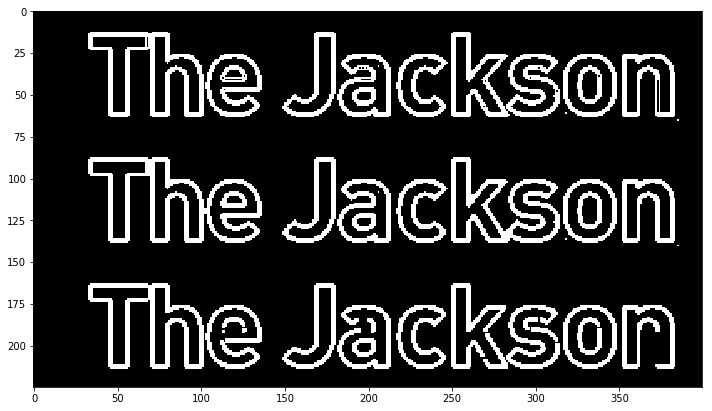

In [17]:
# In this case, closing cleared out some gaps in the letters, but left a little noise
# opening got rid of noise, but deleted some of the outline

image_row_1 = jax_outline[150:225, 450:850]
image_row_2 = jax_closing[150:225, 450:850]
image_row_3 = jax_opening[150:225, 450:850]

image_row = np.vstack((image_row_1, image_row_2, image_row_3))

io.imshow(image_row);

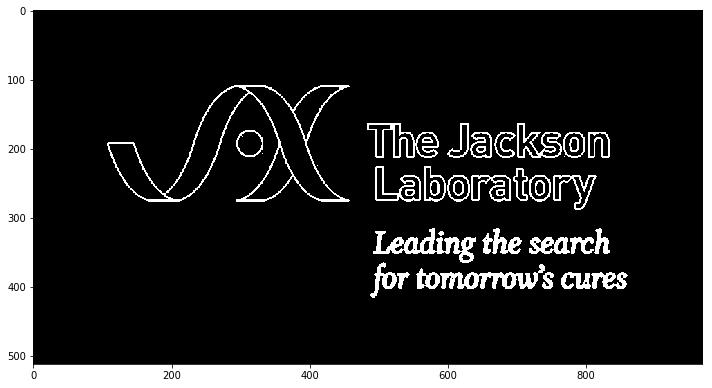

In [18]:
io.imshow(jax_closing);

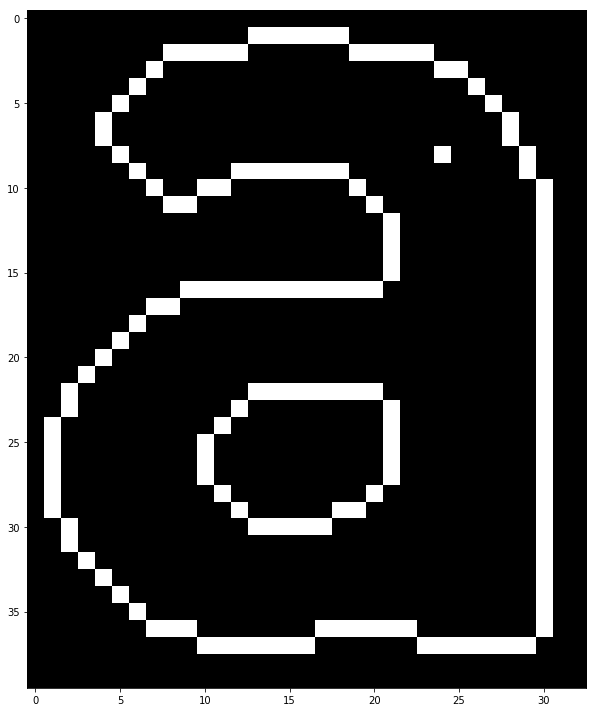

In [19]:
# skeletonize will pare back to a one-pixel-wide line
jax_skeleton = morphology.skeletonize(jax_closing)
io.imshow(jax_skeleton[175:215, 632:665]);

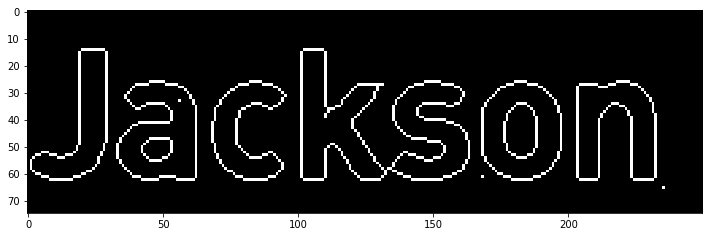

In [20]:
# Note that sometimes the Jupyter rendering looks a little weird
# 'Jackson' looks okay here

io.imshow(jax_skeleton[150:225, 600:850]);

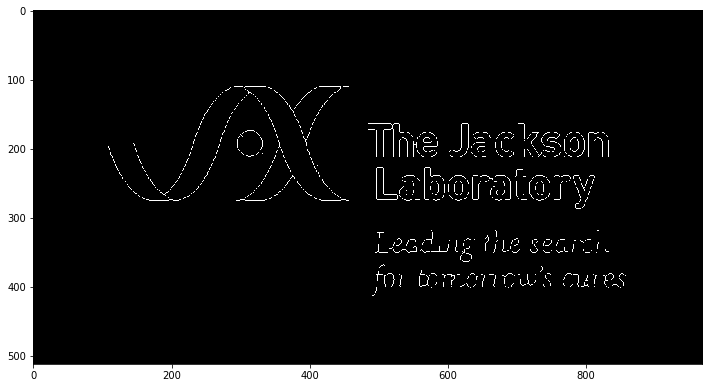

In [21]:
# But 'Jackson' (and everything else) looks bad here, even though we know it's okay
# This is a Jupyter issue.

io.imshow(jax_skeleton);

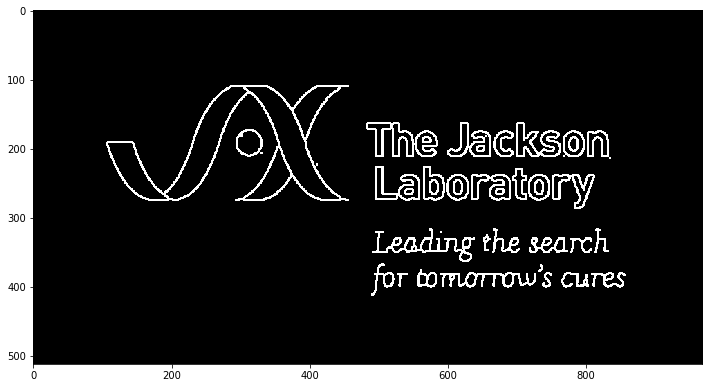

In [22]:
# Thicken skeleton with two rounds of dilation

jax_bordermask = morphology.dilation(jax_skeleton, selem=selem)
jax_bordermask = morphology.dilation(jax_bordermask, selem=selem)
io.imshow(jax_bordermask);

## Some things to do with binary masks

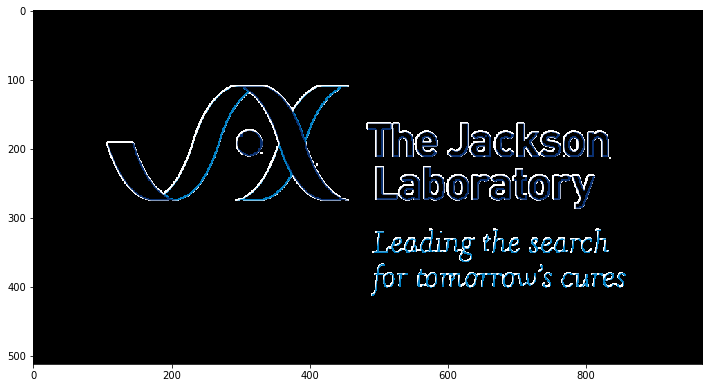

In [23]:
# Binary images can also be used to mask other images
# For example, lets make a new image that takes pixels from the original jax image
# only where we have created our nice outline (jax_bordermask)

jax_color_outline = jax2.copy()

# note: you have to do this for all three color channels!
jax_color_outline[:,:,0] = jax_bordermask * jax2[:,:,0] 
jax_color_outline[:,:,1] = jax_bordermask * jax2[:,:,1]
jax_color_outline[:,:,2] = jax_bordermask * jax2[:,:,2]

io.imshow(jax_color_outline);

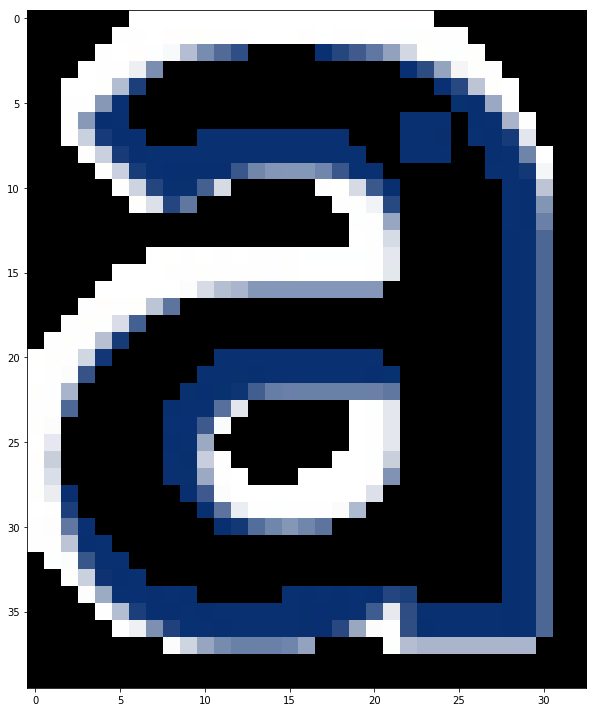

In [24]:
# Here we can see our outline actually lines up pretty well with the original letters

io.imshow(jax_color_outline[175:215, 632:665]);

----
## Slides covering connectivity-based segmentation
---

/anaconda3/envs/ImPyClass/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


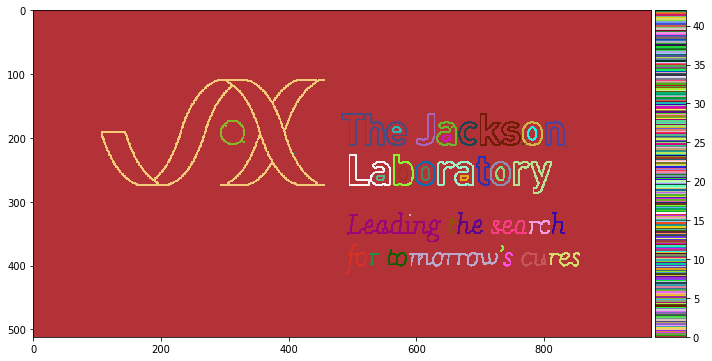

In [25]:
# we can also find all connected regions in a binary mask
# This is very useful for finding and counting objects
jax_label = measure.label(jax_bordermask)

# this is to randomly color our labels (rerun for a different map)
random_cmap = matplotlib.colors.ListedColormap (np.random.rand ( 256,3)) 

io.imshow(jax_label, cmap=random_cmap);

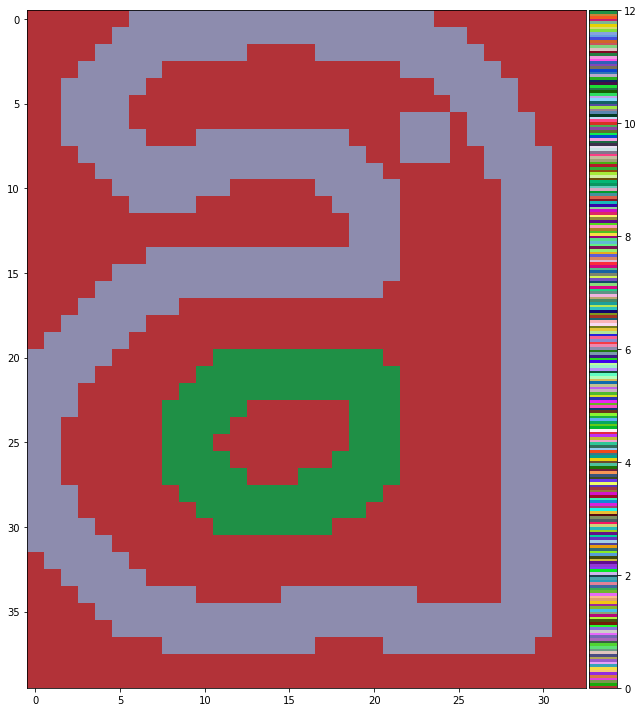

In [26]:
io.imshow(jax_label[175:215, 632:665], cmap=random_cmap); 

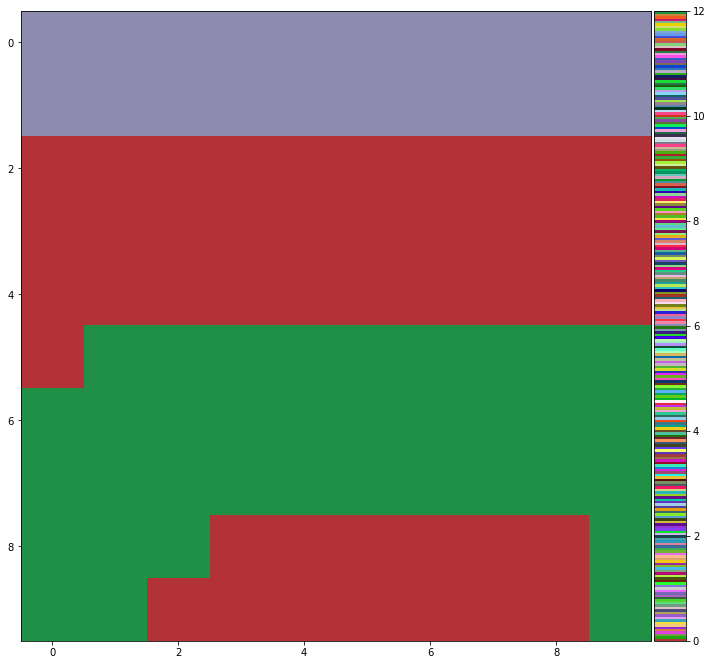

In [27]:
io.imshow(jax_label[190:200, 642:652], cmap=random_cmap);

In [28]:
jax_label[190:200, 642:652]

array([[ 6,  6,  6,  6,  6,  6,  6,  6,  6,  6],
       [ 6,  6,  6,  6,  6,  6,  6,  6,  6,  6],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 12, 12, 12, 12, 12, 12, 12, 12, 12],
       [12, 12, 12, 12, 12, 12, 12, 12, 12, 12],
       [12, 12, 12, 12, 12, 12, 12, 12, 12, 12],
       [12, 12, 12,  0,  0,  0,  0,  0,  0, 12],
       [12, 12,  0,  0,  0,  0,  0,  0,  0, 12]])

In [29]:
jax_label.max()

42

In [30]:
np.where(jax_label == 42)

(array([380, 380, 380, 380, 381, 381, 381, 381, 381, 381, 381, 381, 381,
        381, 381, 381, 381, 381, 381, 381, 382, 382, 382, 382, 382, 382,
        382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 383, 383, 383,
        383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383,
        384, 384, 384, 384, 385, 385, 385, 386, 386, 386, 387, 387, 387,
        387, 388, 388, 388, 388, 389, 389, 389, 390, 390, 390, 391, 391,
        391, 392, 392, 392, 393, 393, 393, 394, 394, 394, 395, 395, 395,
        396, 396, 396, 396, 397, 397, 397, 397, 398, 398, 398, 398, 399,
        399, 399]),
 array([527, 528, 529, 530, 526, 527, 528, 529, 530, 531, 532, 533, 534,
        535, 536, 537, 538, 539, 540, 541, 526, 527, 528, 529, 530, 531,
        532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 526, 527, 528,
        529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541,
        530, 531, 532, 533, 530, 531, 532, 530, 531, 532, 529, 530, 531,
        532, 529, 530, 531, 532

## Exercise

1. Create a new image from the "coins" example in scikit-image
```python
from skimage import data
coins = data.coins()
```
2. Write a script to automatically count the number of coins. This does not have to be perfect! You can do a decent job using only what you have learned in this workshop.

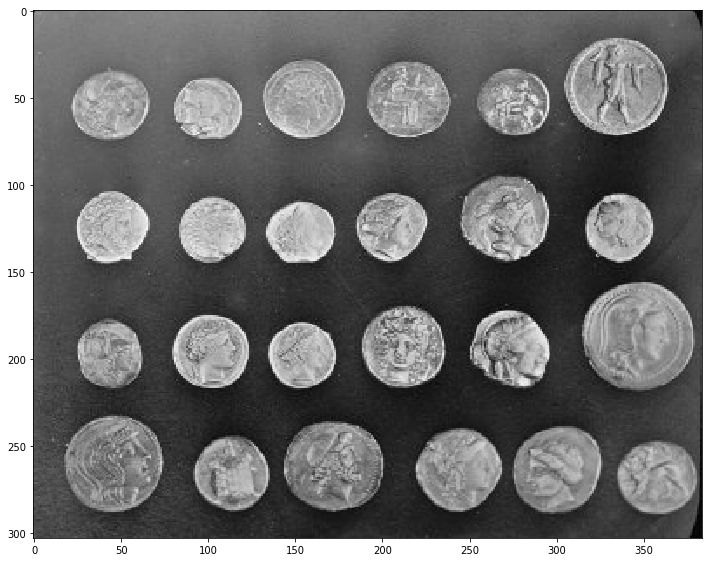

In [31]:
from skimage import data
coins = data.coins()
io.imshow(coins);

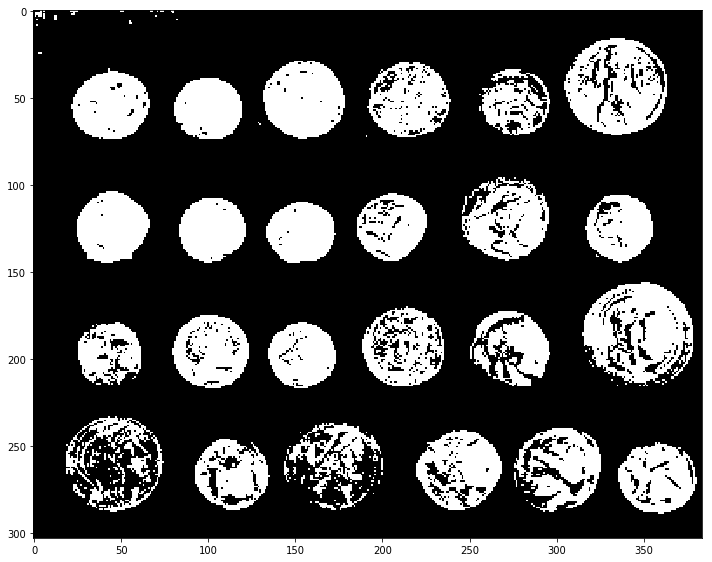

In [32]:
# Try a simple threshold
coins_thresh = coins > 135
io.imshow(coins_thresh);

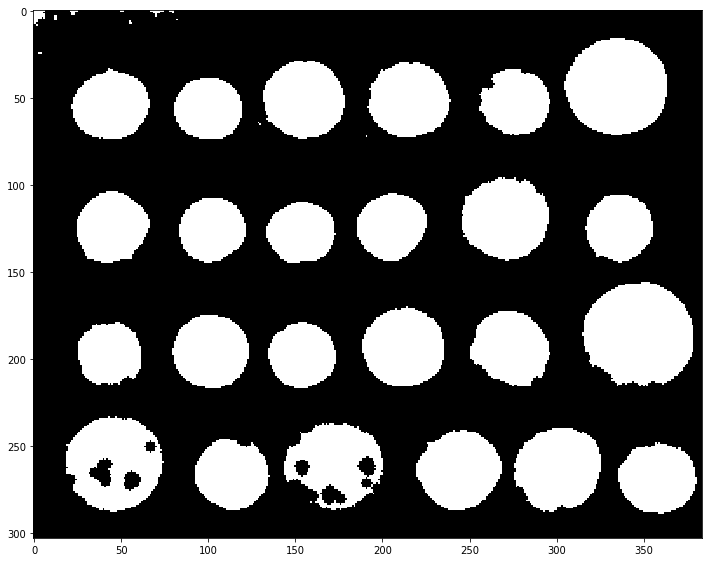

In [33]:
# try a closing to make sure all pixels within a coin are connected
selem = morphology.disk(3)
coins_closed = morphology.closing(coins_thresh, selem=selem)
io.imshow(coins_closed);

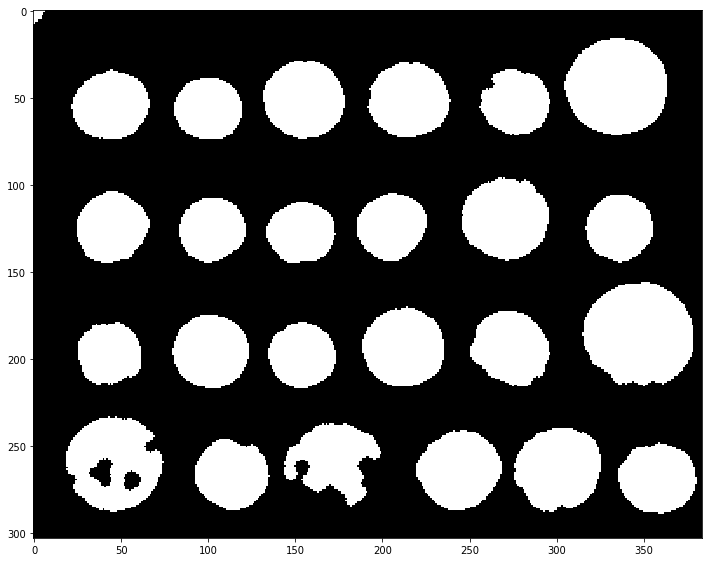

In [34]:
# opening will clean up some noise
selem = morphology.disk(3)
coins_opened = morphology.opening(coins_closed, selem=selem)
io.imshow(coins_opened);

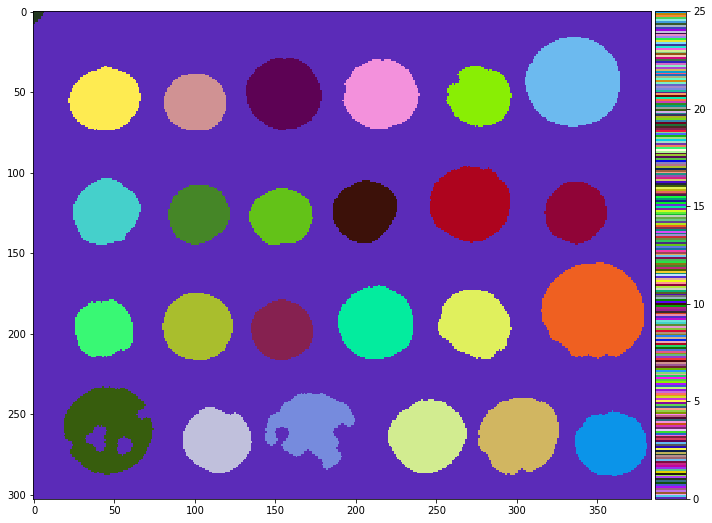

In [35]:
# find connected regions and check 
coins_label = measure.label(coins_opened)
random_cmap = matplotlib.colors.ListedColormap (np.random.rand ( 256,3)) 

io.imshow(coins_label, cmap=random_cmap);

In [36]:
# remember background is zero, so the max value will be equal to the number of
# non-background objects
coins_label.max()

25

In [37]:
# answer is off by one, but this nearly worked and was very simple!
# How might you do better?
# How well would this approach work on a different coin image? What problems might you encounter?